In [1]:
import torch
import numpy as np

from mmdet.apis import init_detector, inference_detector
from mmdet.utils import get_test_pipeline_cfg

import mmcv
from mmcv.transforms import Compose
from mmengine.visualization import Visualizer

from mmdet.visualization import local_visualizer as lv
from mmdet.evaluation.functional import get_classes

/home/zhangna/anaconda3/envs/openmmlab1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# faster rcnn 第一阶段产生的proposal box

In [57]:
config_file = "/home/zhangna/VOC_detection/mmdetection/models_r50_voc0712_original/faster-rcnn_r50_fpn_1x_voc0712_original.py"
checkpoint_file = "/home/zhangna/VOC_detection/mmdetection/models_r50_voc0712_original/epoch_4.pth" # 请将训练好的权重文件放在该位置

In [65]:
image_file = "/home/zhangna/VOC_detection/test_image/OOD4.jpg"

In [59]:
device = "cuda:0"
model = init_detector(config_file, checkpoint_file, device=device)

Loads checkpoint by local backend from path: /home/zhangna/VOC_detection/mmdetection/models_r50_voc0712_original/epoch_4.pth


In [5]:
def load_data(model, image):
    cfg = model.cfg.copy()
    test_pipeline = get_test_pipeline_cfg(cfg)
    if isinstance(image, np.ndarray):
        test_pipeline[0].type = "mmdet.LoadImageFromNDArray"
    test_pipeline = Compose(test_pipeline)
    data = test_pipeline(dict(img_path=image))
    data["inputs"] = [data["inputs"]]
    data["data_samples"] = [data["data_samples"]]
    return data

In [31]:
data = load_data(model, image_file)
with torch.no_grad():
    feature = model.extract_feat(data["inputs"][0].unsqueeze(0).float().cuda())
    (cls_scores, bbox_shift) = model.rpn_head.forward(feature)
    anchor_generator = model.rpn_head.prior_generator
    feature_map_size = [feature[i].size()[-2:] for i in range(len(feature))]
    anchors = anchor_generator.grid_priors(feature_map_size, device=device)

In [38]:
cls_scores = [cls_score.squeeze() for cls_score in cls_scores]
bbox_shift = [shift.squeeze() for shift in bbox_shift]

boxes = model.rpn_head._predict_by_feat_single(
    cls_score_list = cls_scores,
    bbox_pred_list = bbox_shift,
    score_factor_list = None,
    mlvl_priors = anchors,
    img_meta = data["data_samples"][0].to_dict(),
    cfg = None,
    rescale = True,
)

/home/zhangna/VOC_detection/mmengine/mmengine/visualization/visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/home/zhangna/VOC_detection/mmengine/mmengine/visualization/visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


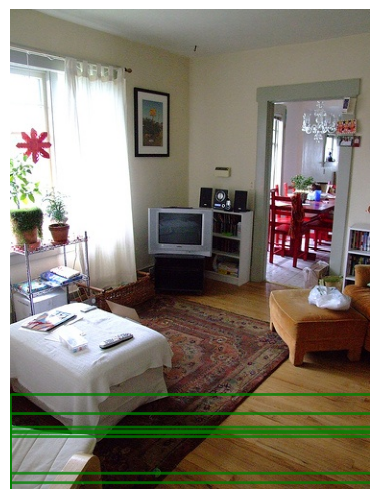

In [39]:
boxes.bboxes[0:5]
visualizer = Visualizer(image=mmcv.imread(image_file,channel_order='rgb'));
visualizer.draw_bboxes(boxes.bboxes[0:100]); #[0:100]
visualizer.show()

# faster rcnn 测试结果

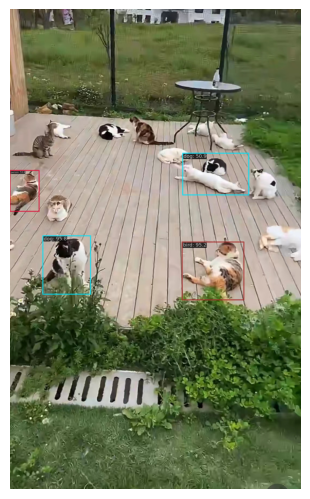

In [66]:
result = inference_detector(model, image_file)

visualizer = lv.DetLocalVisualizer()
class_names = get_classes("voc")
visualizer.dataset_meta["classes"] = class_names
visualizer.dataset_meta["palette"] = [
    (106, 0, 228),
    (119, 11, 32),
    (165, 42, 42),
    (0, 0, 192),
    (197, 226, 255),
    (0, 60, 100),
    (0, 0, 142),
    (255, 77, 255),
    (153, 69, 1),
    (120, 166, 157),
    (0, 182, 199),
    (0, 226, 252),
    (182, 182, 255),
    (0, 0, 230),
    (220, 20, 60),
    (163, 255, 0),
    (0, 82, 0),
    (3, 95, 161),
    (0, 80, 100),
    (183, 130, 88),
]
visualizer.add_datasample(
            "Plot1",
            mmcv.imread(image_file,channel_order='rgb'),
            result,
            draw_gt= False,
            draw_pred = True,
            show = True,
            wait_time = 0,
            out_file = None, #image_file.replace('test_image', 'test_image/out').replace('.jpg', '_pred.jpg'),
            pred_score_thr = 0.3,
            step = 0);

visualizer.show()

# yolov3 测试结果

In [49]:
config_file = "/home/zhangna/VOC_detection/mmdetection/models_yolo_bs16/yolo_r50_fpn_1x_voc0712.py"
checkpoint_file = "/home/zhangna/VOC_detection/mmdetection/models_yolo_bs16/epoch_6.pth"

# config_file = "/home/zhangna/VOC_detection/mmdetection/models_yolo_bs16_pretrain/yolo_r50_fpn_1x_voc0712.py"
# checkpoint_file = "/home/zhangna/VOC_detection/mmdetection/models_yolo_bs16_pretrain/epoch_2.pth"

device = "cuda:0"
model = init_detector(config_file, checkpoint_file, device=device)

Loads checkpoint by local backend from path: /home/zhangna/VOC_detection/mmdetection/models_yolo_bs16/epoch_6.pth


In [55]:
image_file = "/home/zhangna/VOC_detection/test_image/OOD1.jpg"

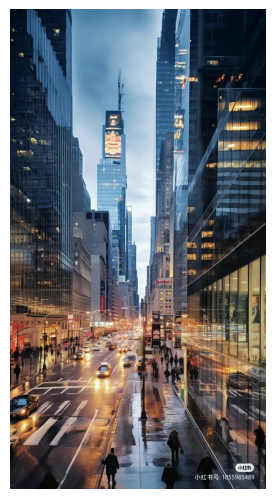

In [56]:
result = inference_detector(model, image_file)
visualizer = lv.DetLocalVisualizer()
class_names = get_classes("voc")
visualizer.dataset_meta["classes"] = class_names
visualizer.dataset_meta["palette"] = [
    (106, 0, 228),
    (119, 11, 32),
    (165, 42, 42),
    (0, 0, 192),
    (197, 226, 255),
    (0, 60, 100),
    (0, 0, 142),
    (255, 77, 255),
    (153, 69, 1),
    (120, 166, 157),
    (0, 182, 199),
    (0, 226, 252),
    (182, 182, 255),
    (0, 0, 230),
    (220, 20, 60),
    (163, 255, 0),
    (0, 82, 0),
    (3, 95, 161),
    (0, 80, 100),
    (183, 130, 88),
]
visualizer.add_datasample(
            "Plot1",
            mmcv.imread(image_file,channel_order='rgb'),
            result,
            draw_gt= False,
            draw_pred = True,
            show = True,
            wait_time = 0,
            out_file = None,
            pred_score_thr = 0.3,
            step = 0);
visualizer.show()